## Spatial Autocorrelation and Regression Analysis
In this tutorial, you will calculate a global Moran's I statistic to evaluate spatial autocorrelation in your data, and then explore different methods to account for spatial autocorrelation in your data. Specifically, we'll compare parameter estimates relating county income to 2016 county voting preferences using an OLS model, and autoregressive model, and an autocovariance function model.

While not entirely environmental in analysis, it is an election year, and this analysis is extremely generalizable to many environmental applications.

In [1]:
import pysal as ps
import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from libpysal.weights.contiguity import Queen
import libpysal
from splot.libpysal import plot_spatial_weights
from splot.esda import moran_scatterplot
from splot.esda import plot_moran
from esda.moran import Moran_Local
from esda.moran import Moran
from statsmodels.api import OLS
from pysal.model import spreg
sns.set_style('white')


First, we're going to load the 'Elections' dataset from the libpysal library:

In [2]:
from libpysal.examples import load_example
elections = load_example('Elections')

Click on this url to learn more about the variables in this dataset: https://geodacenter.github.io/data-and-lab//county_election_2012_2016-variables/

As you can see, there are a lot of data values available in this dataset. We're most interested in seeing whether income (INC910213) factored heavily in the percent change in democratic vote between 2012-2016 for the county (pct_pt_16).

In [3]:
#First, let's see what files are available in the 'Elections' data example
elections.get_file_list()

['/Users/peterbrennan/pysal_data/Elections/__MACOSX/election/._election.shp',
 '/Users/peterbrennan/pysal_data/Elections/election/election.prj',
 '/Users/peterbrennan/pysal_data/Elections/election/election.shx',
 '/Users/peterbrennan/pysal_data/Elections/election/election.shp',
 '/Users/peterbrennan/pysal_data/Elections/election/election.dbf']

<AxesSubplot:>

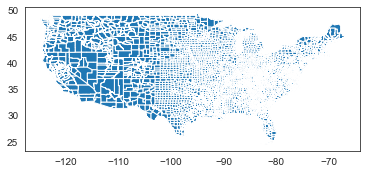

In [4]:
#We'll read this shapefile in as a geopandas dataframe (using gpd)
#View the shapefile to get a general idea of the geometry that we're working with 
votes = gpd.read_file(elections.get_path('election.shp'))
%matplotlib inline
votes.plot()

In [5]:
#View the first few line]s of the dataset
votes.head()

,STATEFP,COUNTYFP,GEOID,ALAND,AWATER,area_name,state_abbr,PST045214,PST040210,PST120214,...,total_2012,Demvotes12,GOPvotes12,county_fip,state_fips,pct_dem_12,pct_gop_12,diff_2012,pct_pt_12,geometry
0,01,005,01005,2.291821e+09,50864677.0,Barbour County,AL,26887.0,27457.0,-2.1,...,11459.0,5873.0,5539.0,5.0,1.0,0.512523,0.483376,334.0,0.029147,"POLYGON ((-85.74803 31.61918, -85.74544 31.618..."
1,01,023,01023,2.365955e+09,19059247.0,Choctaw County,AL,13323.0,13858.0,-3.9,...,7965.0,3785.0,4150.0,23.0,1.0,0.475204,0.521030,365.0,-0.045825,"POLYGON ((-88.47323 31.89386, -88.46888 31.930..."
2,01,035,01035,2.201896e+09,6643480.0,Conecuh County,AL,12670.0,13228.0,-4.2,...,7013.0,3551.0,3434.0,35.0,1.0,0.506345,0.489662,117.0,0.016683,"POLYGON ((-87.42720 31.26436, -87.42551 31.268..."
3,01,051,01051,1.601877e+09,99850740.0,Elmore County,AL,80977.0,79296.0,2.1,...,35440.0,8940.0,26223.0,51.0,1.0,0.252257,0.739927,17283.0,-0.487669,"POLYGON ((-86.41333 32.75059, -86.37115 32.750..."
4,01,065,01065,1.667805e+09,32525874.0,Hale County,AL,15184.0,15760.0,-3.7,...,8628.0,5401.0,3205.0,65.0,1.0,0.625985,0.371465,2196.0,0.254520,"POLYGON ((-87.87046 32.76244, -87.86818 32.765..."


In [6]:
#Since there are too many columns for us to view on a signle page using "head", we can just print out hte column names so we have them all listed for reference
for col in votes.columns: 
    print(col) 

STATEFP
COUNTYFP
GEOID
ALAND
AWATER
area_name
state_abbr
PST045214
PST040210
PST120214
POP010210
AGE135214
AGE295214
AGE775214
SEX255214
RHI125214
RHI225214
RHI325214
RHI425214
RHI525214
RHI625214
RHI725214
RHI825214
POP715213
POP645213
POP815213
EDU635213
EDU685213
VET605213
LFE305213
HSG010214
HSG445213
HSG096213
HSG495213
HSD410213
HSD310213
INC910213
INC110213
PVY020213
BZA010213
BZA110213
BZA115213
NES010213
SBO001207
SBO315207
SBO115207
SBO215207
SBO515207
SBO415207
SBO015207
MAN450207
WTN220207
RTN130207
RTN131207
AFN120207
BPS030214
LND110210
POP060210
Demvotes16
GOPvotes16
total_2016
pct_dem_16
pct_gop_16
diff_2016
pct_pt_16
total_2012
Demvotes12
GOPvotes12
county_fip
state_fips
pct_dem_12
pct_gop_12
diff_2012
pct_pt_12
geometry


### You can use pandas summary statistics to get an idea of how county-level data varies across the united states. For example, how did the county mean percent Democratic vote change between 2012 and 2016?

In [7]:
print(votes['pct_dem_12'].mean())
print(votes['pct_dem_16'].mean())

0.384501897042471
0.31666743004440157


Look here for more info on pandas summary statistics:https://www.earthdatascience.org/courses/intro-to-earth-data-science/scientific-data-structures-python/pandas-dataframes/run-calculations-summary-statistics-pandas-dataframes/

We can also plot histograms of the data. Below, smoothed histograms from the seaborn package (imported as sns) let us get an idea of the distribution of percent democratic votes in 2012 and 2016 (right.

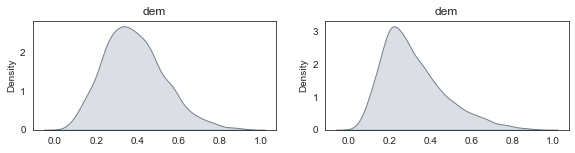

In [8]:
f,ax = plt.subplots(1,2, figsize=(2*3*1.6, 2))
for i,col in enumerate(['pct_dem_12','pct_dem_16']):
    sns.kdeplot(votes[col].values, shade=True, color='slategrey', ax=ax[i])
    ax[i].set_title(col.split('_')[1])

We can see that the distribution of percent democratic votes changed a bad, mainly the mean shifted to the left. Let's look at this trend in space:

/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/seaborn/distributions.py:1649: FutureWarning: The `vertical` parameter is deprecated and will be removed in a future version. Assign the data to the `y` variable instead.
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/seaborn/distributions.py:1649: FutureWarning: The `vertical` parameter is deprecated and will be removed in a future version. Assign the data to the `y` variable instead.
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/seaborn/distributions.py:1649: FutureWarning: The `vertical` parameter is deprecated and will be removed in a future version. Assign the data to the `y` variable instead.
  warnings.warn(msg, FutureWarning)


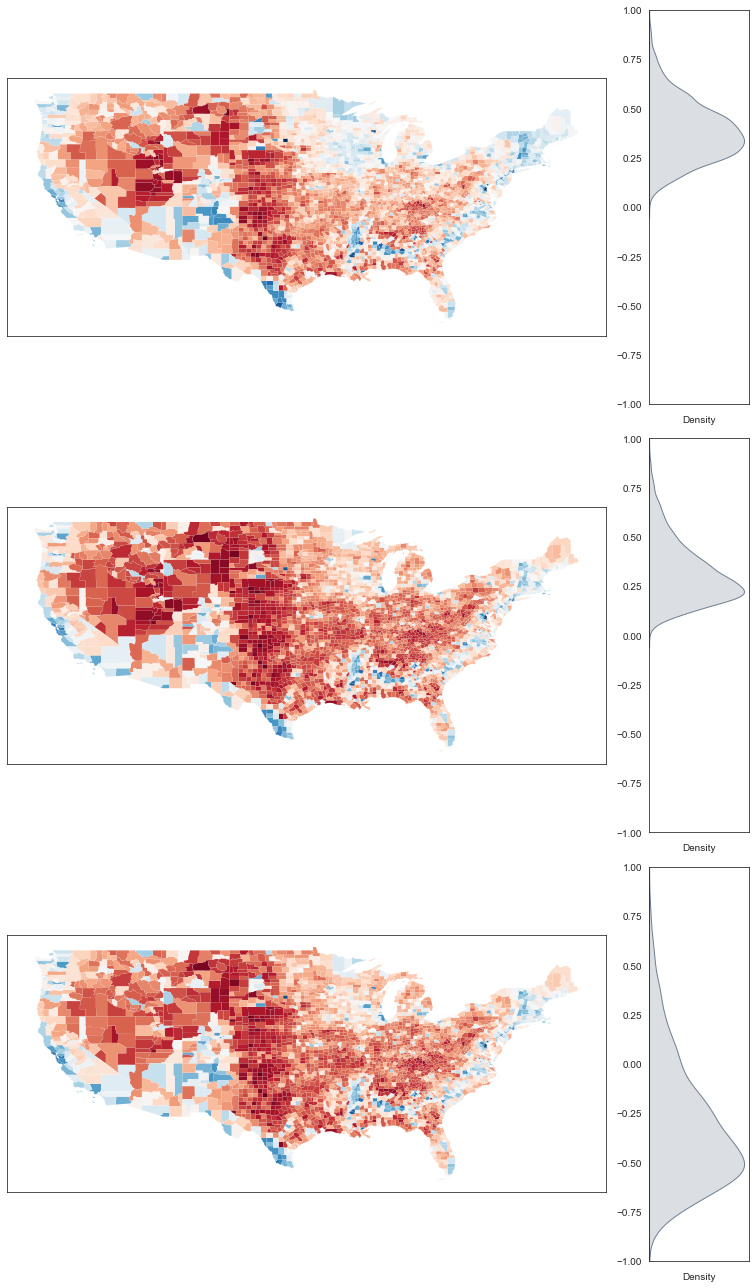

In [9]:
f,ax = plt.subplots(3,2, figsize=(1.6*6 + 1,6*3), gridspec_kw=dict(width_ratios=(6,1)))
for i,col in enumerate(['pct_dem_12','pct_dem_16', 'pct_pt_16']):
    votes.plot(col, linewidth=.05, cmap='RdBu', ax=ax[i,0])
    #ax[i,0].set_title(col.split('_')[1] + ' Two Party Vote (% Dem)')
    ax[i,0].set_xticklabels('')
    ax[i,0].set_yticklabels('')
    sns.kdeplot(votes[col].values, ax=ax[i,1], vertical=True, shade=True, color='slategrey')
    ax[i,1].set_xticklabels('')
    ax[i,1].set_ylim(-1,1)
f.tight_layout()
plt.show()

### Was the county wide percent change in democratic vote related to per capita income?
The next question is how can we use robust statistics to determine whether per capita income was related to a chance in 2016 voting preferences. To do this, we're going to conduct a linear regression relating our parameters in pct_pr_16 to INC910213. Then, we're going to use the confidence interval around beta hat (our slope parameter estimate) to determine whether it is significantly different than zero.

First we're going to visualize how these variables relate in the global data:

In [10]:
votes.dropna(subset=['pct_dem_12','pct_dem_16'], inplace=True)

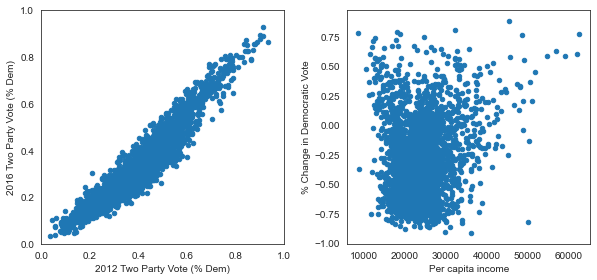

In [11]:
f,ax = plt.subplots(1,2, figsize=(4*2.1,4))
votes[['pct_dem_12','pct_dem_16']].plot.scatter('pct_dem_12','pct_dem_16', ax=ax[0])
ax[0].set_xlabel('2012 Two Party Vote (% Dem)')
ax[0].set_ylabel('2016 Two Party Vote (% Dem)')
ax[0].axis([0,1,0,1])
r = np.corrcoef(votes['pct_dem_12'].values, votes['pct_dem_16'].values)[0,1]


votes[['INC910213','pct_pt_16']].plot.scatter('INC910213','pct_pt_16', ax=ax[1])
ax[1].set_xlabel('Per capita income')
ax[1].set_ylabel('% Change in Democratic Vote')
r = np.corrcoef(votes['pct_pt_16'].values, votes['INC910213'].values)[0,1]

f.tight_layout()
plt.show()

What we're looking at in the first plot is the 2012 percent democratic vote and the 2016 percent democratic vote. In the second plot, we're looking at how per capital income (x axis) relates to % change in democratic vote. We want to establish a trendline in the second plot, and determine if the slope in that trendline is statistically significant.

### Unmute yourself, or enter into the Zoom chat window, what are some features of this data that it look well-suited for linear regression? What are some features of this data that make it poorly suited for linear regression?

## Do we have spatial autocorrelation in our data?
When we're looking at distributions of voting preferences, remember that we're aggregating these numbers over arbitrary (er...political) geographic regions. Each column in that dataframe represents a data value summarized over a US county, but US counties have widely different land areas and populations:

Text(0.5, 0, '2014 County Population')

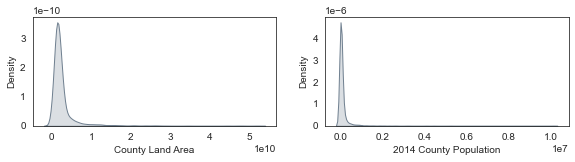

In [12]:
f,ax = plt.subplots(1,2, figsize=(2*3*1.6, 2))
sns.kdeplot(votes['ALAND'].values, shade=True, color='slategrey', ax=ax[0])
ax[0].set_xlabel('County Land Area')

sns.kdeplot(votes['PST045214'].values, shade=True, color='slategrey', ax=ax[1])
ax[1].set_xlabel('2014 County Population')

To a certain extent, our data grouping (by county) may not represent an accurate sampling granularity of our spatial or human populuation. First, let's focus on the spatial componnet: the fact that these counties are different sizes. If we want to identify spatial autocorrelation in our data, we need to first understand how this spatial autocorrelation decays as a function of distance. On Tuesday, we calculated the Moran's I statistic, which you can think of as the "slope" that we'd get when we regress data values for all geographic entities with data values that neighbor within a given distance. Lets look at our data in lat/lon space again:

<AxesSubplot:>

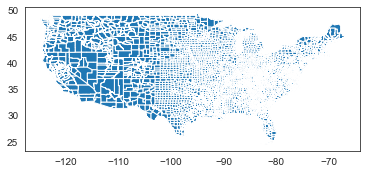

In [13]:
votes.plot()

In [14]:
#Convert coordinate reference system to NAD83 / Conus Albers (EPSG 5070)
votes.crs = {'init':'epsg:4326'}
votes = votes.to_crs(epsg='5070')

/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


<AxesSubplot:>

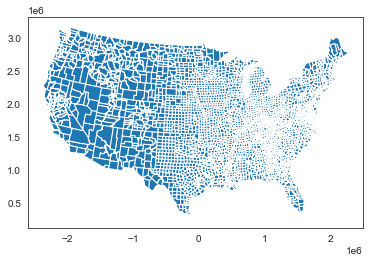

In [15]:
#Let's look at the data again:
votes.plot()

One issue is that we're sampling spatially at a distinct, and heterogenous, granulatiry. The smallest unit of measurement available in our dataset is the county level. Counties are different sizes. How can we evaluate whether this spatial sampling granularity is of sufficient resolution to capture the scale of variability in our dataset?

*If we are sampling at too course of a spatial scale, we run the risk of **missing key patterns of variability in our data** *

*If we are sampling at too fine of a sptial scale, we run the risk of **violating assumptions of independence between our individual observations** *

## TASK 1: In your own words, describe how the spatial sampling scale of "county" might represent and oversampling or undersampling of data as it relates to our question (did per capital income impact change in voting preference

Answer here: Because some counties contain a majority of citizens while others contain a very small proportion of citizens, it seems that a sampling scale of county might not accurately represent per capita income as it relates to voting preference (i.e. undersampling).

### Calculating a weights matrix:
The first thing we want to tackle is a quantification of any spatial autocorrelation in our dataset. Spatial autocorrelation inflates our theoretical number of samples (N). *When we're calculating test statistics, spatial autocorrelation in our data can make it seem like parameters that are unimportant are actually significant.* 

Since we're dealing with a heterogeneous sampling grid in our data, the first thing we want to do is calculate a weights matrix.

We're going to use the Queen function in pysal to do this. Full documentation here: https://pysal.org/libpysal/generated/libpysal.weights.Queen.html

Or just use the built in help with the function below:

In [16]:
??Queen

#Click the "X" in the upper right corner of that help window that pops up to close it.

/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 4 disconnected components.
 There are 3 islands with ids: 1267, 2729, 2763.
  warnings.warn(message)


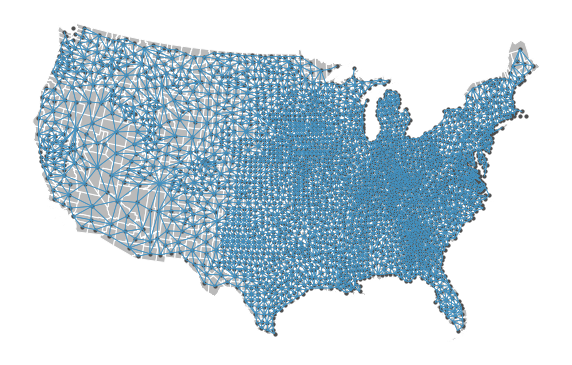

In [17]:
#Calculate weights object
weights = Queen.from_dataframe(votes)

#Use built in plot function to visualize how the weights matrix works
plot_spatial_weights(weights, votes)
plt.show()


The verticies in this plot represent two things: first, the identify neigbors based on the model parameters we set for defining neighborhood (here we use the defaul settings and consider any contiguous polygons). It also calculates the distance between those centers (length of the verticies). "Neighbors" that are father matter less than "neighbors" that are closer in identifying the strength of spatial autocorrelation.

## TASK 2: Why did we convert the coordinate reference system?

To visually identify where spatial autocorrelation is strongest.

('WARNING: ', 1267, ' is an island (no neighbors)')
('WARNING: ', 2729, ' is an island (no neighbors)')
('WARNING: ', 2763, ' is an island (no neighbors)')


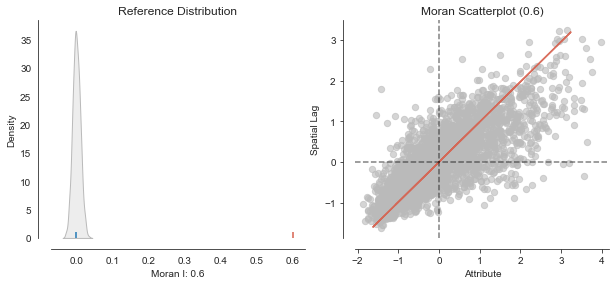

In [18]:
# calculate Moran and plot
moran = Moran(votes['pct_dem_16'], w=weights)
plot_moran(moran, zstandard=True, figsize=(10,4))
plt.show()

## TASK 3: Do we have statistically significant evidence (at alpha = 0.05) of spatial autocorrelation in our response variable (Percent change in democratic vote, or pct_pt_16)?

*Use code cell below as your "calculator". Double click on this cell and enter answer here*

Yes we do; p_norm = 0.0

In [20]:
# What is the null hypothesis?
# What is the alternative hypothesis?
# What is our test statistic?
# How can we derive the test statistic from our "moran" object?
# HINT:
moran.p_norm

0.0

### Caluculate a linear regression on the global data:
In this next step, we're going to calculate a linear regression in our data an determine whether that analysis determines a statistically significant relationship between our percent income and percent change in democratic vote.

In [21]:
#first, forumalate the model. See weather_trend.py in "Git_101" for a refresher on how.

#extract variable that you want to use to "predict"
X = np.array(votes['PST045214'].values)

#extract variable that we want to "predict"
Y = np.array(votes['pct_dem_16'].values)

lm = OLS(Y,X)
lm_results = OLS(Y,X).fit().summary()

In [22]:
print(lm_results)

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.170
Model:                            OLS   Adj. R-squared (uncentered):              0.170
Method:                 Least Squares   F-statistic:                              636.1
Date:                Thu, 29 Oct 2020   Prob (F-statistic):                   7.61e-128
Time:                        11:33:12   Log-Likelihood:                         -873.69
No. Observations:                3108   AIC:                                      1749.
Df Residuals:                    3107   BIC:                                      1755.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

## TASK 4: Do we have evidence (at alpha = 0.05) of a statistically significant relationship between pct_pt_16 and PST045214? How does PST045214 impact pct_pt_16? Use numbers to back your claim.

Yes; p-value is essentially 0 for the observed least squares (OLS) fit, suggesting the relationship between the change in democratic votes and change in per-capita income is not random (null hypothesis can be rejected).

Now, let's plot our residuals to see if there are any spatial patterns in them.

Remember residuals = predicted - fitted values


In [24]:
#Add model residuals to our "votes" geopandas dataframe:
votes['lm_resid']=lm.fit().resid


Remember, in OLS regression we depend out our residuals being normally distributed:

Text(0.5, 16.200000000000003, 'OLS residuals')

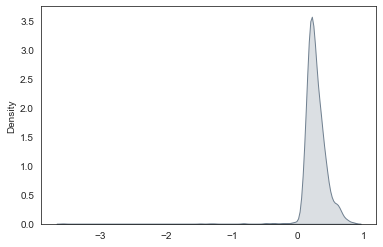

In [25]:
sns.kdeplot(votes['lm_resid'].values, shade=True, color='slategrey')
ax[1].set_xlabel('OLS residuals')

<AxesSubplot:>

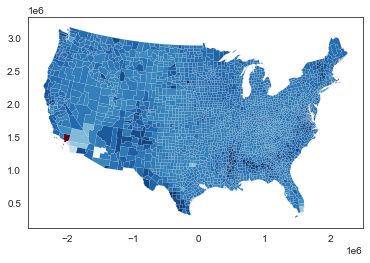

In [26]:
#Plot them in spac:
votes.plot('lm_resid', linewidth=.05, cmap='RdBu')

So, these are very *not* normal residuals. What's going on?

## TASK 5: What does a positive residual mean here (the model overpredicted change in democratic vote, the model underpredicted change in democratic vote)?
A positive residual suggests that the predicted change in democratic vote was less than the actual change (the model underpredicted change in democratic vote).

One way we can evaluate whether spatial autocorrelation has impacted our results is if we see spatial autocorrelation in the residuals:

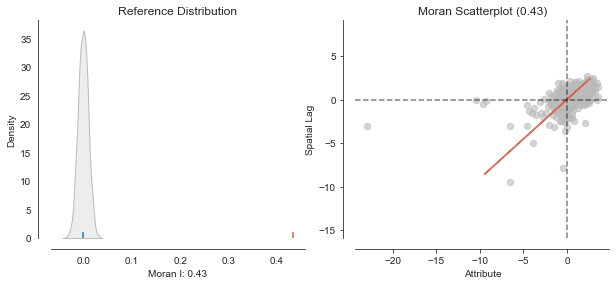

In [27]:
# calculate Moran and plot
moran = Moran(votes['lm_resid'], w=weights)
plot_moran(moran, zstandard=True, figsize=(10,4))
plt.show()

## TASK 5: Do we have correlated residuals (use numbers to back your answer)?

## Autocovariate regression: spatial lag model
Let's see if we can get different answers by accounting for our residuals in our model. First, we'll try a spatial lag model. A spatial lag model is a type of autocovariate model that assumes that dependencies exist directly among the levels of the dependent variable, and models them as an "autocovariate". So we create an autocovariate function that describes the degree to which the percent change in democratic vote at one location is affected by the percent change in democratic vote at the nearby locations. The coefficient and p-value for the autocovariate function are interpreted as for the independent variables. 


In [28]:
X = np.array(votes['PST045214'].values).T
X.shape = (len(Y),1)
Y = np.array(votes['pct_dem_16'].values).T
Y.shape = (len(Y),1)

lag=spreg.ML_Lag(Y, X, weights)
print(lag.summary)
#mi = ps.Moran(lag.u, w, two_tailed=False)
#pd.Series(index=['Morans I','Z-Score','P-Value'],data=[mi.I, mi.z_norm, mi.p_norm])

/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/scipy/optimize/_minimize.py:778: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  "defaulting to absolute tolerance.", RuntimeWarning)
/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :     dep_var                Number of Observations:        3108
Mean dependent var  :      0.3167                Number of Variables   :           3
S.D. dependent var  :      0.1533                Degrees of Freedom    :        3105
Pseudo R-squared    :      0.5986
Spatial Pseudo R-squared:  0.1551
Sigma-square ML     :       0.010                Log likelihood        :    2584.230
S.E of regression   :       0.099                Akaike info criterion :   -5162.461
                                                 Schwarz criterion     :   -5144.336

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----------------------------

Text(0.5, 16.200000000000003, 'SLM residuals')

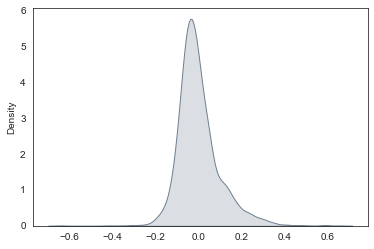

In [29]:
#Add model residuals to our "votes" geopandas dataframe:
votes['slm_resid']=lag.u
sns.kdeplot(votes['slm_resid'].values, shade=True, color='slategrey')
ax[1].set_xlabel('SLM residuals')

<AxesSubplot:>

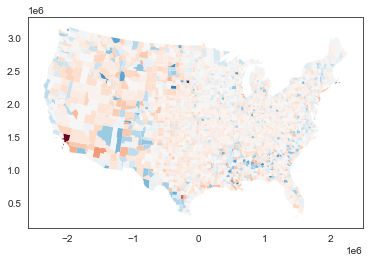

In [30]:
#Plot them in spac:
votes.plot('slm_resid', linewidth=.05, cmap='RdBu')

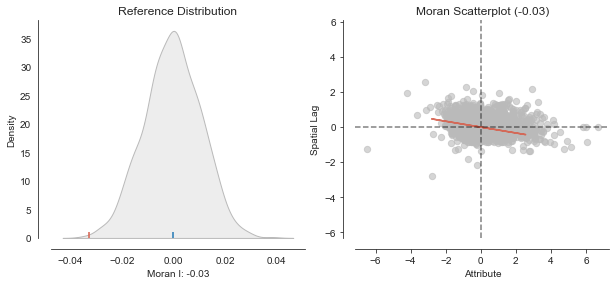

In [31]:
# calculate Moran and plot
moran = Moran(votes['slm_resid'], w=weights)
plot_moran(moran, zstandard=True, figsize=(10,4))
plt.show()

## TASK 6: When we account for spatial autocorrelation in our data using the spatial lag model, do we still see a significant relationship between our response and predictor variable? Do you think this is a valid approach? Why or why not?


## Spatial autoregressive model (maximum likelihood spatial error model)
Instead of modelling spatial dependence using an autocovariate, we use a similar type of weight structure (here called "lambda") to weight the error matrix:

In [32]:
error = spreg.ML_Error(Y, X, weights)
print(error.summary)


/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/scipy/optimize/_minimize.py:778: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  "defaulting to absolute tolerance.", RuntimeWarning)


REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL ERROR (METHOD = FULL)
-------------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :     dep_var                Number of Observations:        3108
Mean dependent var  :      0.3167                Number of Variables   :           2
S.D. dependent var  :      0.1533                Degrees of Freedom    :        3106
Pseudo R-squared    :      0.1211
Sigma-square ML     :       0.009                Log likelihood        :    2606.785
S.E of regression   :       0.097                Akaike info criterion :   -5209.571
                                                 Schwarz criterion     :   -5197.487

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----------------------------------------------------------

Text(0.5, 16.200000000000003, 'MLError residuals')

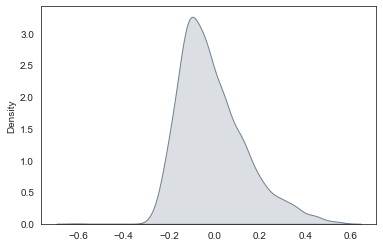

In [33]:
#Add model residuals to our "votes" geopandas dataframe:
votes['mlError_resid']=error.u
sns.kdeplot(votes['mlError_resid'].values, shade=True, color='slategrey')
ax[1].set_xlabel('MLError residuals')

<AxesSubplot:>

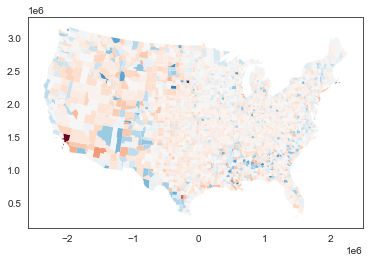

In [34]:
#Plot them in spac:
votes.plot('slm_resid', linewidth=.05, cmap='RdBu')

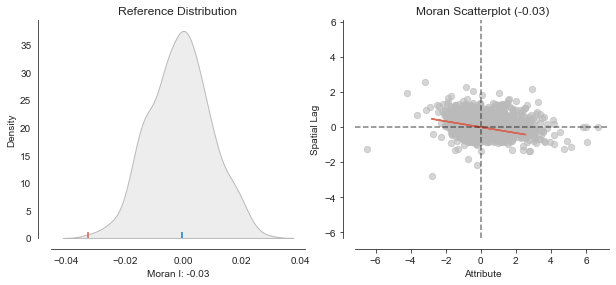

In [35]:
# calculate Moran and plot
moran = Moran(votes['slm_resid'], w=weights)
plot_moran(moran, zstandard=True, figsize=(10,4))
plt.show()

## TASK 7: Given these three models, do you believe that there is a relationship between percent change in democratic vote and income level? Why or why not?

I do not think there is due to the spatial autocorrelation seen in the data and the moran's I statistic. Though there is a chance, indicated by the PDF figure directly above showing the distribution of the possible Moran's I values, that this is a possible value (-0.03), it is very unlikely.